In [1]:
!pip uninstall tensorflow --yes
!pip install tensorflow_decision_forests
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 --yes
!pip install kerassurgeon 

Found existing installation: tensorflow 2.6.4
Uninstalling tensorflow-2.6.4:
  Successfully uninstalled tensorflow-2.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found

In [11]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import glob
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import datasets, layers, models,Input,Model 
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import  Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow.keras.metrics import Accuracy, Recall,Precision
from sklearn.tree import DecisionTreeClassifier as Decisiontree
from sklearn.svm import SVC as Supportvectorclassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
from functools import reduce
from kerassurgeon.operations import delete_layer, insert_layer
from keras.utils import to_categorical
import pickle
from sklearn.metrics import ConfusionMatrixDisplay

# load files from original model

## hist

In [3]:
with open("../input/originalmodeloutputs/original_hist.pkl","rb") as file:
    hist=pickle.load(file)

2022-11-14 10:13:30.331988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 10:13:30.436452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 10:13:30.437422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 10:13:30.438893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

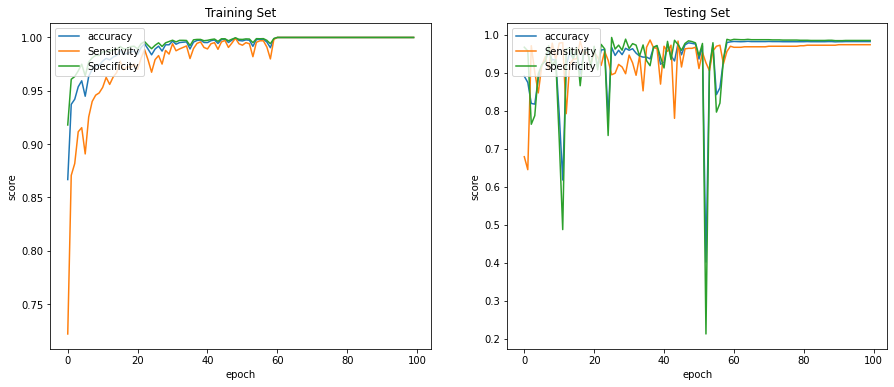

In [4]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(hist.history['val_accuracy'])
ax[1].plot(hist.history['val_Sensitivity'])
ax[1].plot(hist.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['Sensitivity'])
ax[0].plot(hist.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('xray data31.png')

In [5]:
model = keras.models.load_model('../input/datafromoriginalmodel/my_model')
train_ds=tf.data.Dataset.load("../input/datafromoriginalmodel/train_ds")
test_ds=tf.data.Dataset.load("../input/datafromoriginalmodel/test_ds")

In [6]:
# feature extraction model

feature_extractor=Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="flatten_layer").output,name="Feature_extractor"
)
#feature_extractor.summary()

In [34]:
# getting training set features and labels

# feature matrix 
features=feature_extractor.predict(train_ds)

# labels
def labels(tfdata):
    labels=[]
    for batch in tfdata:
        image,lab=batch
        lab=lab.numpy()
        labels.append(lab)
    labels=np.concatenate(labels)
    return labels

def two_cat_to_one(labels):
    lls=[]
    for label in labels:
        lls.append(label[1])
    return lls

labs=two_cat_to_one(labels(train_ds))
# getting testing set features
# feature matrix

st = time.time()
features_test=feature_extractor.predict(test_ds)
et = time.time()

# labels
lab_test=two_cat_to_one(labels(test_ds))

elapsed_time=round((et - st)/features_test.shape[0],4)
elapsed_time

346/346 [==============================] - 40s 115ms/step


2022-11-14 11:21:06.354128: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1832564736 exceeds 10% of free system memory.


87/87 [==============================] - 10s 116ms/step


0.0039

In [32]:
model.evaluate(test_ds)

87/87 [==============================] - 12s 126ms/step - loss: 0.1958 - accuracy: 0.9841 - Sensitivity: 0.9754 - Specificity: 0.9872 - Precision: 0.9649 - f1_score: 0.9841


[0.19578522443771362,
 0.9840637445449829,
 0.9754098653793335,
 0.9871857762336731,
 0.9648648500442505,
 0.9840637445449829]

87/87 [==============================] - 10s 121ms/step


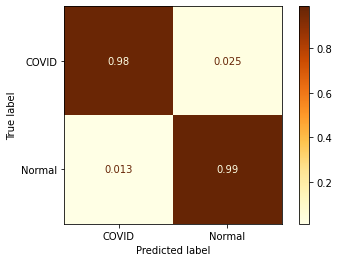

In [35]:
pred=np.round(two_cat_to_one(model.predict(test_ds)))
ConfusionMatrixDisplay.from_predictions(lab_test,pred,display_labels=['COVID', 'Normal'],
                             cmap="YlOrBr",normalize='true')
plt.savefig('ll.png')

# load corona hack data

In [3]:

with open("../input/threebenchmark/Coronahack_hist.pkl","rb") as file:
    hist=pickle.load(file)

2022-11-08 12:59:59.031436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 12:59:59.140953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 12:59:59.141767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 12:59:59.143037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

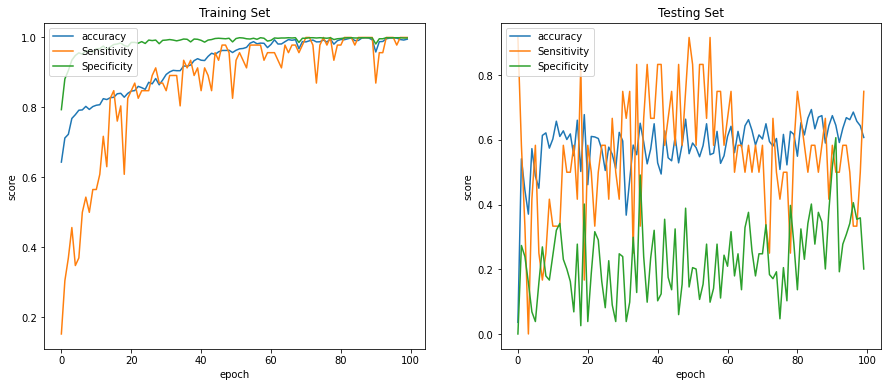

In [22]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(hist.history['val_accuracy'])
ax[1].plot(hist.history['val_Sensitivity'])
ax[1].plot(hist.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['Sensitivity'])
ax[0].plot(hist.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('coronahack data31.png')

# load chest xray history

In [23]:
with open("../input/threebenchmark/Chestxray_hist.pkl","rb") as file:
    hist=pickle.load(file)

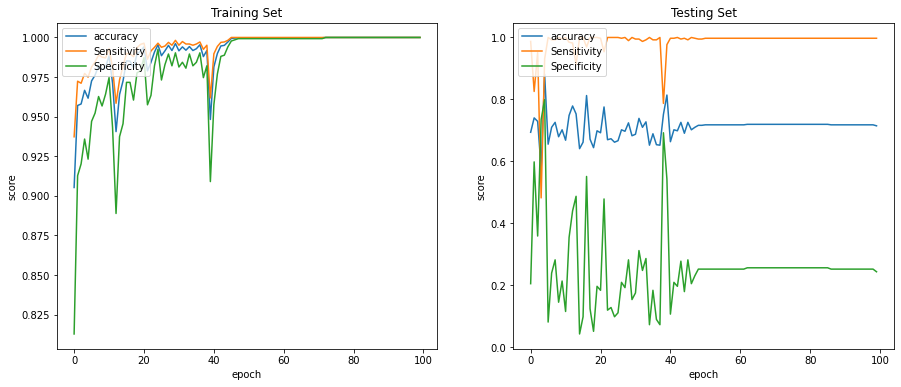

In [25]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(hist.history['val_accuracy'])
ax[1].plot(hist.history['val_Sensitivity'])
ax[1].plot(hist.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['Sensitivity'])
ax[0].plot(hist.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('xray data31.png')

# load chest pneumonia model history

In [26]:
with open("../input/threebenchmark/covidpneumoniaNormal_hist.pkl","rb") as file:
    hist=pickle.load(file)

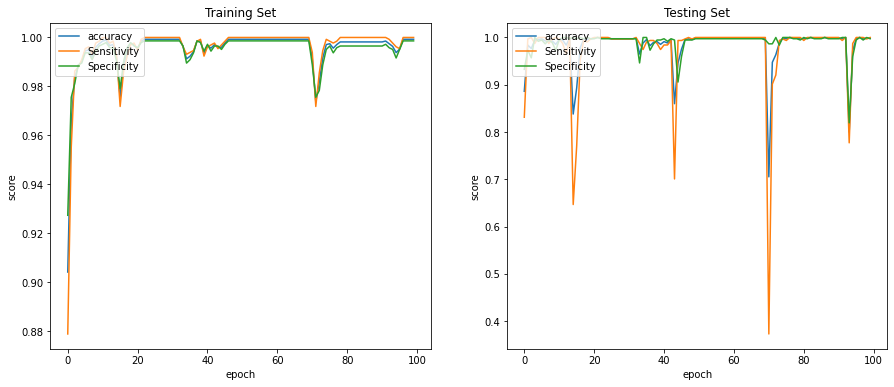

In [27]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(hist.history['val_accuracy'])
ax[1].plot(hist.history['val_Sensitivity'])
ax[1].plot(hist.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['Sensitivity'])
ax[0].plot(hist.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('xray data31.png')

# load patch camelyon histoy

In [28]:
with open("../input/patchcamelyon/patchcamelyon.pkl","rb") as file:
    hist=pickle.load(file)


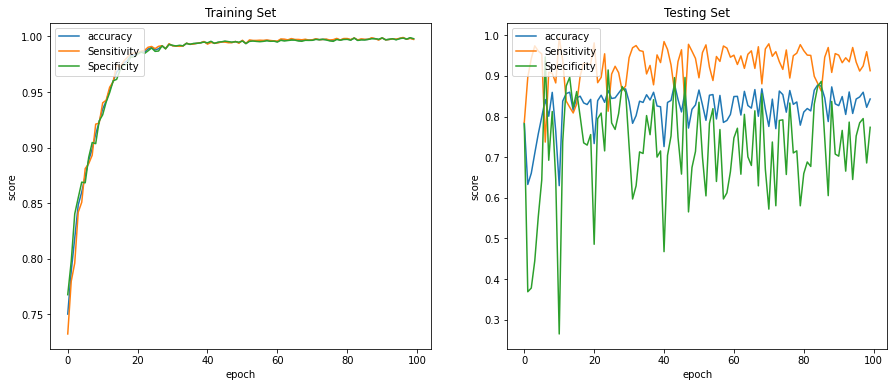

In [29]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[1].plot(hist.history['val_accuracy'])
ax[1].plot(hist.history['val_Sensitivity'])
ax[1].plot(hist.history['val_Specificity'])
#ax[1].plot(hist.history['val_Precision'])
#ax[1].plot(hist.history['val_f1_score'])
ax[1].set_title('Testing Set')
ax[1].set_ylabel('score')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')

# Accuracy
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['Sensitivity'])
ax[0].plot(hist.history['Specificity'])
#ax[0].plot(hist.history['Precision'])
#ax[0].plot(hist.history['f1_score'])
ax[0].set_title('Training Set')
ax[0].set_ylabel('score')
ax[0].set_xlabel('epoch')
ax[0].legend(['accuracy','Sensitivity','Specificity','Precision','F1 score'], loc='upper left')
plt.savefig('xray data31.png')

# loading Logistic regression model

In [8]:
with open("../input/lower-part/logistic.pkl","rb") as file:
    logistic_model=pickle.load(file)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


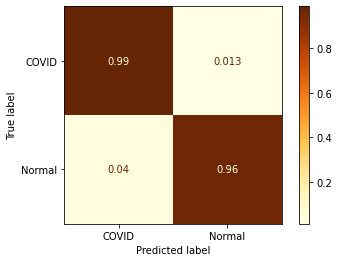

In [13]:
pred=logistic_model.predict(features_test)
cm = metrics.confusion_matrix(lab_test, pred)
metrics.plot_confusion_matrix(logistic_model,features_test,lab_test,display_labels=['COVID', 'Normal'],
                             cmap="YlOrBr",normalize='true')
plt.savefig('logistic.png')

In [15]:
with open("../input/lower-part/DT.pkl","rb") as file:
    DT=pickle.load(file)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


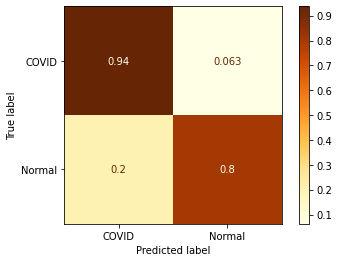

In [16]:
pred=DT.predict(features_test)
cm = metrics.confusion_matrix(lab_test, pred)
metrics.plot_confusion_matrix(DT,features_test,lab_test,display_labels=['COVID', 'Normal'],
                             cmap="YlOrBr",normalize='true')
plt.savefig('DT.png')

# support vector

In [8]:
with open("../input/support-vector/SVCm.pkl","rb") as file:
    SVCm=pickle.load(file)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


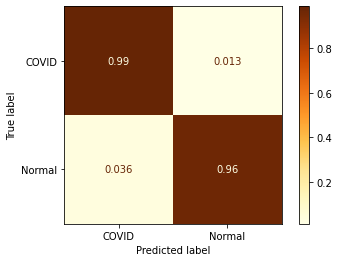

In [9]:
pred=SVCm.predict(features_test)
cm = metrics.confusion_matrix(lab_test, pred)
metrics.plot_confusion_matrix(SVCm,features_test,lab_test,display_labels=['COVID', 'Normal'],
                             cmap="YlOrBr",normalize='true')
plt.savefig('SVCm.png')

# Random forest model.

In [6]:
with open("../input/random-forest/RF.pkl","rb") as file:
    RF=pickle.load(file)

In [8]:
pred=RF.predict(features_test)
cm = metrics.confusion_matrix(lab_test, pred)
metrics.plot_confusion_matrix(RF,features_test,lab_test,display_labels=['COVID', 'Normal'],
                             cmap="YlOrBr",normalize='true')
plt.savefig('DT.png')

NameError: name 'features_test' is not defined